170498071/170498071 [==============================] - 2s 0us/step


5/5 [==============================] - 0s 14ms/step
Epoch 1/100, Discriminator Loss Real: 0.01204238086938858, Discriminator Loss Fake: 0.6148400902748108, GAN Loss: 1.0116372108459473
5/5 [==============================] - 0s 9ms/step
Epoch 2/100, Discriminator Loss Real: 0.0030803424306213856, Discriminator Loss Fake: 0.55572110414505, GAN Loss: 0.9154156446456909
5/5 [==============================] - 0s 9ms/step
Epoch 3/100, Discriminator Loss Real: 0.011369254440069199, Discriminator Loss Fake: 0.225563183426857, GAN Loss: 2.2840816974639893
5/5 [==============================] - 0s 9ms/step
Epoch 4/100, Discriminator Loss Real: 0.1879815310239792, Discriminator Loss Fake: 2.7767817974090576, GAN Loss: 1.564449429512024
5/5 [==============================] - 0s 14ms/step
Epoch 5/100, Discriminator Loss Real: 2.0602089989552042e-07, Discriminator Loss Fake: 0.2958886921405792, GAN Loss: 1.674383282661438
5/5 [==============================] - 0s 9ms/step
Epoch 6/100, Discriminator 

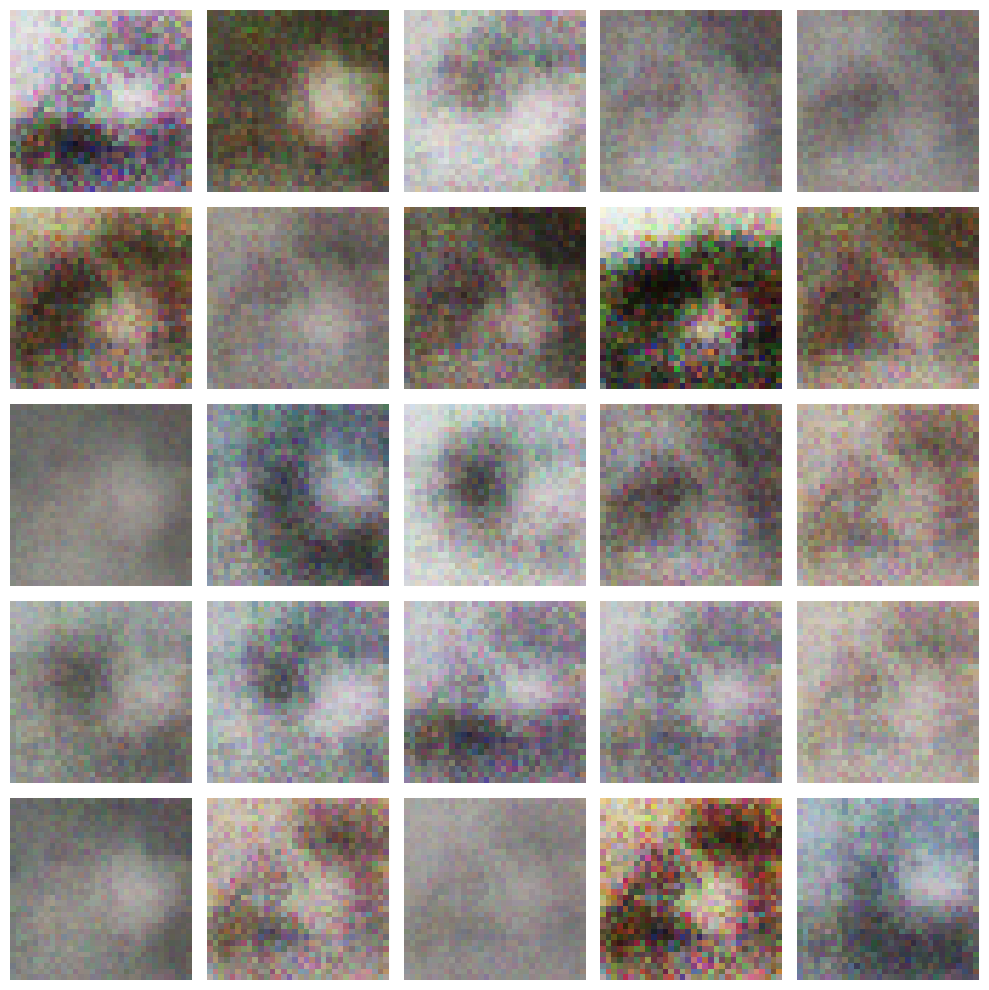

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam

# Load and preprocess the CIFAR-10 dataset
(X_train,_), (_, _) = cifar10.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize pixel values to the range [-1, 1]

# Select only bird images (class label 2 in CIFAR-10)
X_train = X_train[np.where(_ == 2)[0]]

# Define the generator model
generator = Sequential([
    Dense(128, input_shape=(100,), activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(3072, activation='tanh'),  # Output layer with tanh activation to ensure values in range [-1, 1]
    Reshape((32, 32, 3))
])

# Define the discriminator model
discriminator = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compile the discriminator model
discriminator.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Combined model (GAN)
discriminator.trainable = False  # Freeze discriminator during generator training
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Define training parameters
epochs = 100
batch_size = 150

# Training loop
for epoch in range(epochs):
    for batch in range(len(X_train) // batch_size):
        # Train discriminator (real images)
        real_images = X_train[np.random.randint(0, len(X_train), batch_size)]
        labels_real = np.ones((batch_size, 1))
        discriminator_loss_real = discriminator.train_on_batch(real_images, labels_real)

        # Train discriminator (generated images)
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)
        labels_fake = np.zeros((batch_size, 1))
        discriminator_loss_fake = discriminator.train_on_batch(fake_images, labels_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        labels_gan = np.ones((batch_size, 1))
        gan_loss = gan.train_on_batch(noise, labels_gan)

    # Print progress
    print(f'Epoch {epoch + 1}/{epochs}, Discriminator Loss Real: {discriminator_loss_real[0]}, '
          f'Discriminator Loss Fake: {discriminator_loss_fake[0]}, GAN Loss: {gan_loss}')

# Generate and plot images
noise = np.random.normal(0, 1, (25, 100))
generated_images = generator.predict(noise)

plt.figure(figsize=(10, 10))
for i in range(generated_images.shape[0]):
    plt.subplot(5, 5, i + 1)
    plt.imshow((generated_images[i] + 1) / 2)  # Rescale pixel values to range [0, 1]
    plt.axis('off')
plt.tight_layout()
plt.show()